# Upbit API를 이용한 데이터 수집
3초마다 200개의 자료를 수집하여 저장

In [1]:
from datetime import datetime
import pandas as pd
import json

# json to DataFrame
def resToDF(json_text):
    contents = json.loads(json_text)
    contents = pd.DataFrame(contents,columns=[
                                'candle_date_time_kst','opening_price','high_price','low_price',
                                'trade_price','candle_acc_trade_volume','candle_acc_trade_price'])
    contents = contents.set_index('candle_date_time_kst')
    contents.index=pd.to_datetime(contents.index)
    return contents

def get_line_time(file_name, line_number):
    try: 
        with open(file_name, "r") as f:
            line = f.readlines()[line_number].strip().split(",")
            return datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
    except ValueError:
        print("empty file:", file_name)
        return datetime.now()

In [2]:
from modules.local_values import tickers, raw_folder
from datetime import timedelta
import requests
import time

count=200
headers = {"accept": "application/json"}
for tick in tickers:
    file_name=raw_folder+tick+'.csv'
    url=f'https://api.upbit.com/v1/candles/minutes/1?market={tick}&count={count}&to='
    tick_len=0
    to_time = get_line_time(file_name,-1)

    while True:
        to_time=(to_time-timedelta(hours=9)).strftime('%Y-%m-%dT%H:%M:%S')
        response=requests.get(url+to_time, headers=headers)
        contents=resToDF(response.text)
        time.sleep(3)
        if contents.shape[0] != 200:
            print(f'{tick} updates ~ {to_time} = {tick_len} length')
            break
        to_time=contents.index[-1]
        contents.to_csv(file_name,mode='a',header=False)
        tick_len += contents.shape[0]

KRW-BTC updates ~ 2017-09-25T13:14:00 = 0 length
KRW-ETH updates ~ 2017-09-25T03:00:00 = 0 length
KRW-XRP updates ~ 2017-09-25T15:41:00 = 0 length
KRW-SOL updates ~ 2021-10-15T09:24:00 = 0 length
KRW-AVAX updates ~ 2022-02-08T12:01:00 = 0 length
KRW-DOGE updates ~ 2021-02-24T06:40:00 = 0 length
KRW-ETC updates ~ 2017-09-25T21:02:00 = 0 length


### Data 파악
|index|open|high|low|close|volume|value|
|-----|----|----|---|-----|------|-----|
|UTC 기준|시가|고가|저가|종가|누적 거래량|누적 거래금액|

In [3]:
from modules.local_values import tickers, raw_datas
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df.describe()

,open,high,low,close,volume,value
count,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06
mean,2.567209e+07,2.568604e+07,2.565800e+07,2.567199e+07,5.799638e+00,1.490759e+08
std,1.950767e+07,1.951835e+07,1.949693e+07,1.950756e+07,1.097979e+01,3.181951e+08
min,3.565000e+06,3.568000e+06,3.562000e+06,3.565000e+06,1.000000e-08,3.831000e-02
25%,9.383000e+06,9.389000e+06,9.377000e+06,9.383000e+06,9.571221e-01,1.413939e+07
50%,1.930100e+07,1.933000e+07,1.927700e+07,1.930150e+07,2.543780e+00,4.844383e+07
75%,3.854800e+07,3.856600e+07,3.852700e+07,3.854700e+07,6.122392e+00,1.515788e+08
max,8.269000e+07,8.270000e+07,8.261900e+07,8.269900e+07,7.188566e+02,2.516663e+10


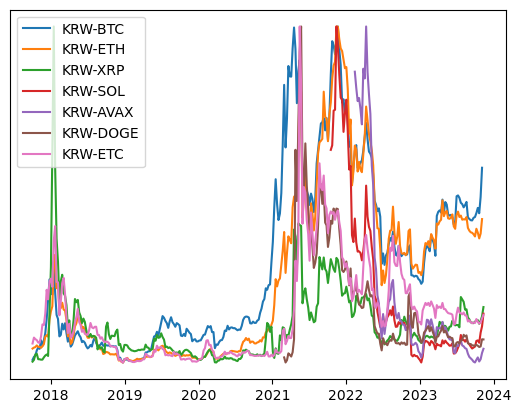

In [5]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='W').first()
    df_min_max=df['close']-df['close'].min()
    df_min_max=df_min_max/df_min_max.max()
    plt.plot(df_min_max,label=tick)

plt.yticks([],[])
plt.legend()
plt.show()

### 결측 데이터 확인
NaN 값 확인

In [6]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='T').first()
    msg='Data{:>9}\tTotal:{:>8}\t NaN:{:7}' \
        .format(tick,len(df),df['open'].isnull().sum())
    print(msg)

Data  KRW-BTC	Total: 3212988	 NaN:  37988
Data  KRW-ETH	Total: 3214676	 NaN: 186610
Data  KRW-XRP	Total: 3216739	 NaN: 200939
Data  KRW-SOL	Total: 1085282	 NaN:  37682
Data KRW-AVAX	Total:  918362	 NaN: 233362
Data KRW-DOGE	Total: 1421425	 NaN:  32825
Data  KRW-ETC	Total: 3218052	 NaN: 849252
